In [6]:
import torch
path_train = '../data/train_data.pkl'
path_val = '../data/val_data.pkl'

# 2 tensors of size 50000 x 3 x H x W
# denoise model with this data
noisy_imgs_1, noisy_imgs_2 = torch.load(path_train)
noisy_imgs_1 = noisy_imgs_1[0:1000]
noisy_imgs_2 = noisy_imgs_2[0:1000]
# Track the progress with this data
noisy_imgs , clean_imgs = torch.load(path_val)
print(noisy_imgs_1.size())
print(noisy_imgs_2.size())
print(noisy_imgs.size())

print(clean_imgs.size())



torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


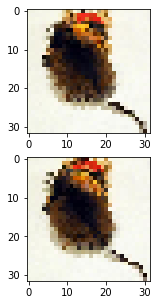

In [25]:
import matplotlib.pyplot as plt
import torchvision.transforms as T 
from PIL import Image

transform = T.ToPILImage()

plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(transform(noisy_imgs_1[100]));
plt.subplot(2,1,2)
plt.imshow(transform(noisy_imgs_2[100]));

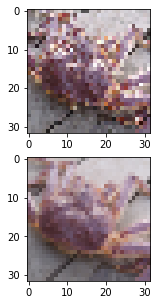

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(transform(noisy_imgs[0]));
plt.subplot(2,1,2)
plt.imshow(transform(clean_imgs[0]));

The goal is to find a model $\phi$:
$$\phi(\hat{X}) = X$$
Quadratic loss: 
$$\hat{w} = argmin \frac{1}{N} \sum_{n=1}^N || x_n - \phi(x_n + \epsilon_n;w) || ^2$$
* $x_n$: data samples
* $\epsilon_n$ : gaussian noise

In [55]:
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 48, 3)
        self.conv2 = nn.Conv2d(48, 48, 3)
        self.conv3 = nn.Conv2d(48, 48, 3)
        self.conv4 = nn.Conv2d(48, 8, 3)
        self.deconv1 = nn.ConvTranspose2d(8, 48, 3)
        self.deconv2 = nn.ConvTranspose2d(48, 48, 3)
        self.deconv3 = nn.ConvTranspose2d(48, 48, 3)
        self.deconv4 = nn.ConvTranspose2d(48, 3, 3)
#         self.maxpool = F.max_pool2d(2)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(F.max_pool2d(x2, kernel_size = 2))
        x4 = self.relu(self.conv3(x3))
        x5 = self.relu(F.max_pool2d(x4, kernel_size = 2))
        x6 = self.relu(self.conv4(x5))
        x7 = self.relu(self.deconv1(x6)) + x5
        x7 = self.relu(self.upsample(x7))
        x7 = self.relu(self.deconv2(x7)) + x3
        x7 = self.relu(self.upsample(x7))
        x7 = self.relu(self.deconv3(x7)) + x1
        x7 = self.relu(self.deconv4(x7)) 
        return x7
#         print(x7)
        

100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


torch.Size([3, 32, 32]) torch.Size([100, 3, 32, 32])


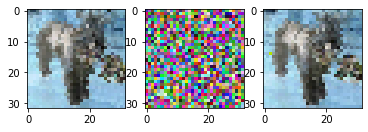

In [56]:
from torch import nn
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_old = nn.Sequential(
    nn.Linear(32, 100),
    nn.ReLU(),
    nn.Linear(100,32)
).to(device)
model = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),    
    nn.Conv2d(32, 8, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(8, 32, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 32, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 32, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, 3)
).to(device)

# model_paper = nn.Sequential(
    
# )
from PIL import Image
import torch 
import torchvision 
import torchvision.transforms as T 
from PIL import Image

transform = T.ToPILImage()
model = Model().to(device)

batch_size, nb_epochs = 100, 100
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
mse = nn.MSELoss()

for e in tqdm(range(nb_epochs)):
    input = noisy_imgs_1.to(device).type(torch.float).split(batch_size)
    target = noisy_imgs_2.to(device).type(torch.float).split(batch_size)
    for i in range(len(input)):
        output = model(input[i])
#         print(model(input[i]))
        loss = mse(output[i], target[i])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(transform(input[i][11]))
plt.subplot(1, 3, 2)
plt.imshow(transform(output[11]))
plt.subplot(1, 3, 3)
plt.imshow(transform(target[i][11]))

print(output[0].size(), target[0].size())



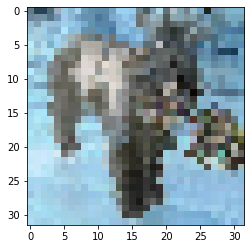

In [20]:
plt.imshow(transform(input[i][11]))
